In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os.path

import keras
import sklearn
import seaborn
import pandas
import numpy
from matplotlib import pyplot as plt

from microesc import urbansound8k, preprocess, train, test, report, stm32convert, stats, models


Using TensorFlow backend.


In [4]:
data = urbansound8k.load_dataset()
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


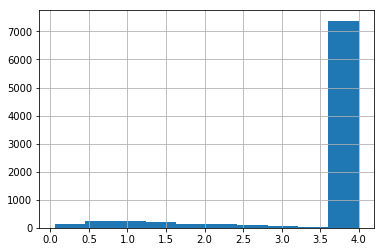

In [157]:
(data.end - data.start).hist()

In [17]:
import json

# TODO: check that MACC is correct wrt given by stm32conv
def load_device_results(results_dir):

    frames = []
    
    for filename in os.listdir(results_dir):
        if filename.endswith('.device.json'):
            experiment = filename.rstrip('.device.json')
            p = os.path.join(results_dir, filename)
            with open(p, 'r') as f:
                contents = f.read()
                contents = contents.replace("'", '"') # hack invalid JSON
                d = json.loads(contents)
                d['experiment'] = experiment
                df = pandas.DataFrame([d])
                frames.append(df)

    df = pandas.concat(frames)
    df.set_index('experiment', inplace=True)
    return df

run = '20190412-1024'
results_dir = os.path.join('./data/results', run)
df = load_device_results(results_dir)
df

,cpu_mhz,cycles_avg,cycles_macc,duration_avg,macc,stack
experiment,,,,,,
0,80,77743690,7.632552,0.971796,10185806,388
4,80,5858230,13.551088,0.073227,432307,292
2,80,6527943,13.678647,0.081599,477236,292
3,80,4932455,14.508458,0.061655,339971,292
1,80,26011364,8.726309,0.325142,2980798,276


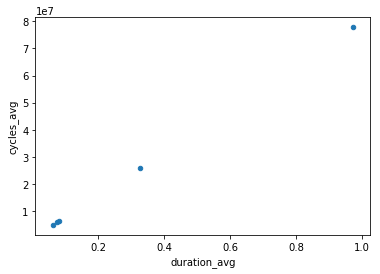

In [18]:
df.plot.scatter(y='cycles_avg', x='duration_avg')

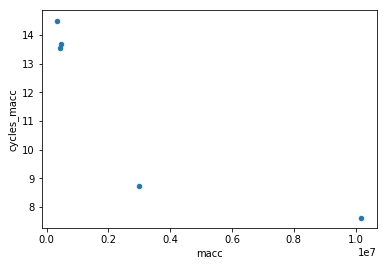

In [20]:
df.plot.scatter(y='cycles_macc', x='macc')

In [22]:
s = {
    'model': 'strided',
    'frames': 31,
    'n_mels': 60,
    'samplerate': 22050,
    'conv_size': (3,3),
    'conv_block': 'effnet',
    'downsample_size': (2,2),
    'n_stages': 3,
    'n_blocks_per_stage': 2,
    'filters': 20,
}
model = models.build(s)
ss, ll = stats.check_model_constraints(model)
ss

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


{'maccs_frame': 843838,
 'flash_usage': 287460.0,
 'ram_usage_max': 56250.0,
 'ram_usage_min': 56250.0}

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 60, 31, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 30, 16, 20)        200       
_________________________________________________________________
conv0_bn (BatchNormalization (None, 30, 16, 20)        80        
_________________________________________________________________
conv0_relu (Activation)      (None, 30, 16, 20)        0         
_________________________________________________________________
conv1pw (Conv2D)             (None, 30, 16, 10)        200       
_________________________________________________________________
conv1pw_bn (BatchNormalizati (None, 30, 16, 10)        40        
_________________________________________________________________
conv1pw_relu (Activation)    (None, 30, 16, 10)        0         
__________

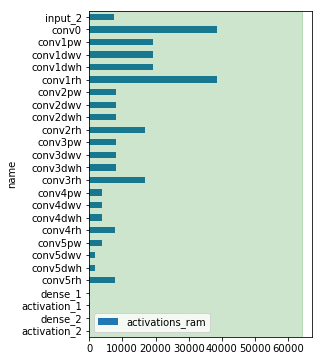

In [24]:
def plot_layers_ram(layers_ram, ax=None, max_ram=64e3):
    
    if not ax:
        fig, ax = plt.subplots(1, figsize=(4, 6))
    
    l = layers_ram.sort_index(ascending=False)
    l['activations_ram'] = 4 * l.activations
    l = l[l.activations_ram.notna()]
    l.plot(kind='barh', ax=ax, y='activations_ram', x='name')
    ax.axvspan(xmin=0, xmax=max_ram, alpha=0.2, color='green')
    
    return fig
    
plot_layers_ram(ll);


In [28]:
model.layers[0].get_output_shape_at(0)

(None, 60, 31, 1)

In [ ]:
# TODO: calculate per-class accuracy. For each fold
# TODO: compare single-frame accuracy (from training) versus voted accuracy
# TODO: compare no-overlap, 50% overlap and 10% overlap